# Hourly Time Series Forecasting using XGBoost

In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly energy consumption.

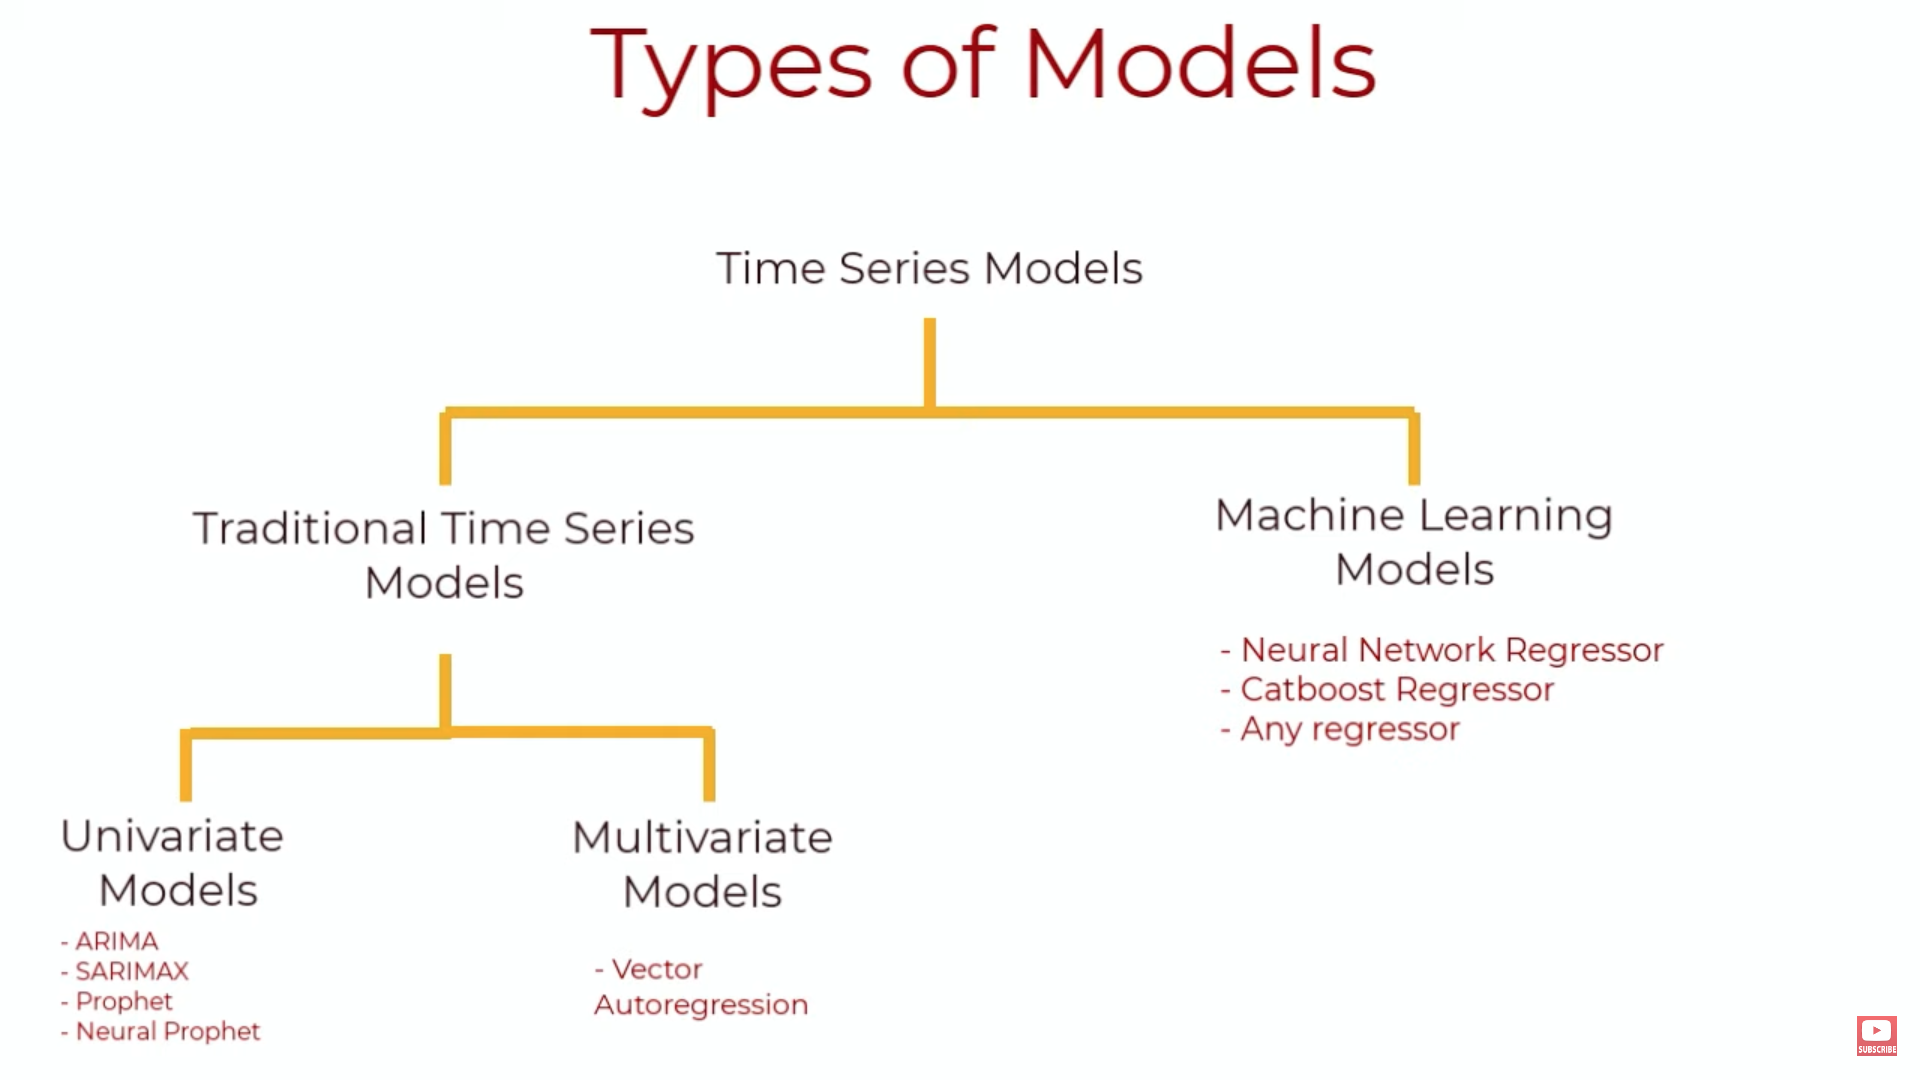

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

[PJM Dataset Description](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

Pulling the `PJM East` which has data from 2004-2018 for the entire east region.

In [ ]:
pjme = pd.read_csv('AEP_hourly.csv', index_col=[0], parse_dates=[0])

In [ ]:
pjme.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
pjme.tail()

,AEP_MW
Datetime,
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0
2018-01-01 23:00:00,20415.0
2018-01-02 00:00:00,19993.0


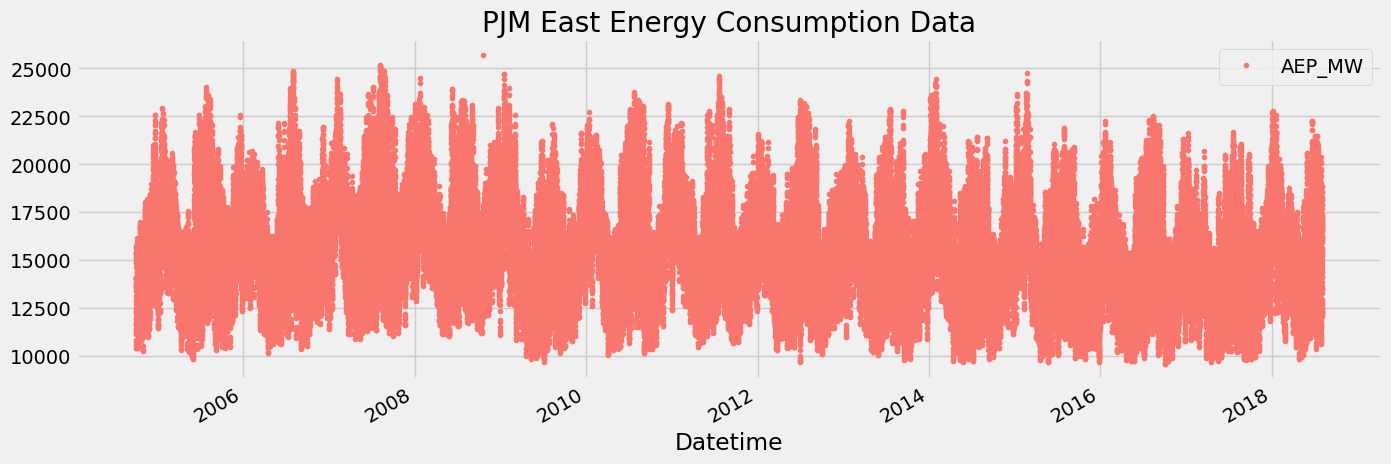

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East Energy Consumption Data')

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [ ]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index < split_date].copy()
pjme_test = pjme.loc[pjme.index >= split_date].copy()

In [ ]:
pjme_train.tail()

,AEP_MW
Datetime,
2014-01-01 20:00:00,16433.0
2014-01-01 21:00:00,16376.0
2014-01-01 22:00:00,16151.0
2014-01-01 23:00:00,15687.0
2014-01-02 00:00:00,15201.0


In [ ]:
pjme_test.head()

,AEP_MW
Datetime,
2015-01-01 00:00:00,16375.0
2015-12-31 01:00:00,12415.0
2015-12-31 02:00:00,12087.0
2015-12-31 03:00:00,12010.0
2015-12-31 04:00:00,11972.0


In [ ]:
pjme_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
Datetime,,
2004-10-01 01:00:00,NaN,12379.0
2004-10-01 02:00:00,NaN,11935.0
2004-10-01 03:00:00,NaN,11692.0
2004-10-01 04:00:00,NaN,11597.0
2004-10-01 05:00:00,NaN,11681.0
...,...,...
2018-08-02 20:00:00,17673.0,NaN
2018-08-02 21:00:00,17303.0,NaN
2018-08-02 22:00:00,17001.0,NaN


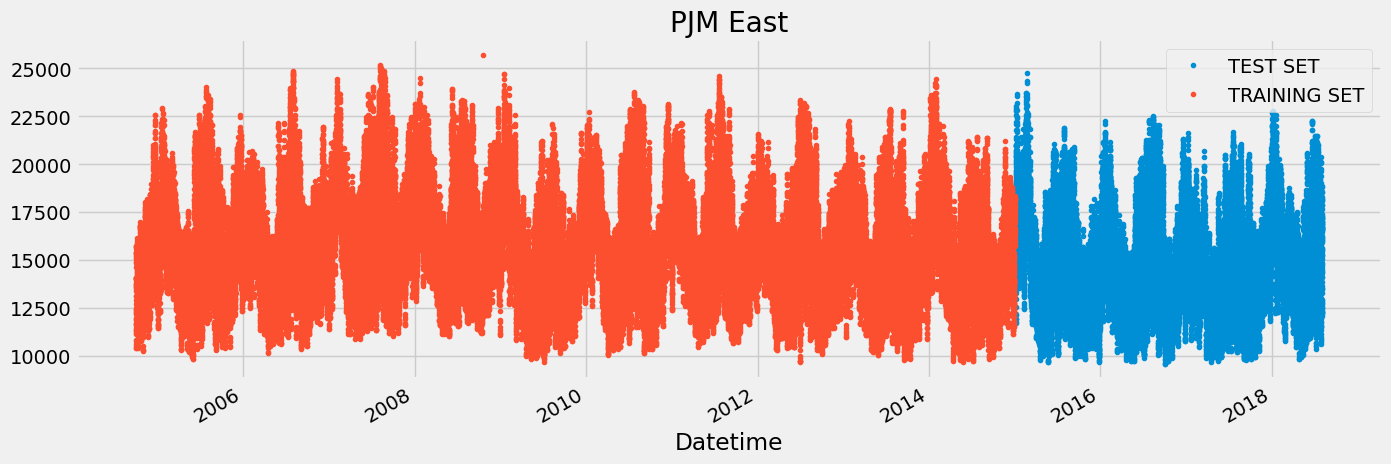

In [ ]:
_ = pjme_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create Time Series Features

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(pjme_train, label='AEP_MW')
X_test, y_test = create_features(pjme_test, label='AEP_MW')

<ipython-input-70-ef221b55ea67>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-70-ef221b55ea67>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [ ]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,5,4,4,12,2004,366,31,53


In [ ]:
y_train.head()

Datetime
2004-12-31 01:00:00    13478.0
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
Name: AEP_MW, dtype: float64

In [ ]:
X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2015-01-01 00:00:00,0,3,1,1,2015,1,1,1
2015-12-31 01:00:00,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,4,3,4,12,2015,365,31,53


# Create XGBoost Model

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        #eval_metric ='mae',
       verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
reg.best_ntree_limit

10

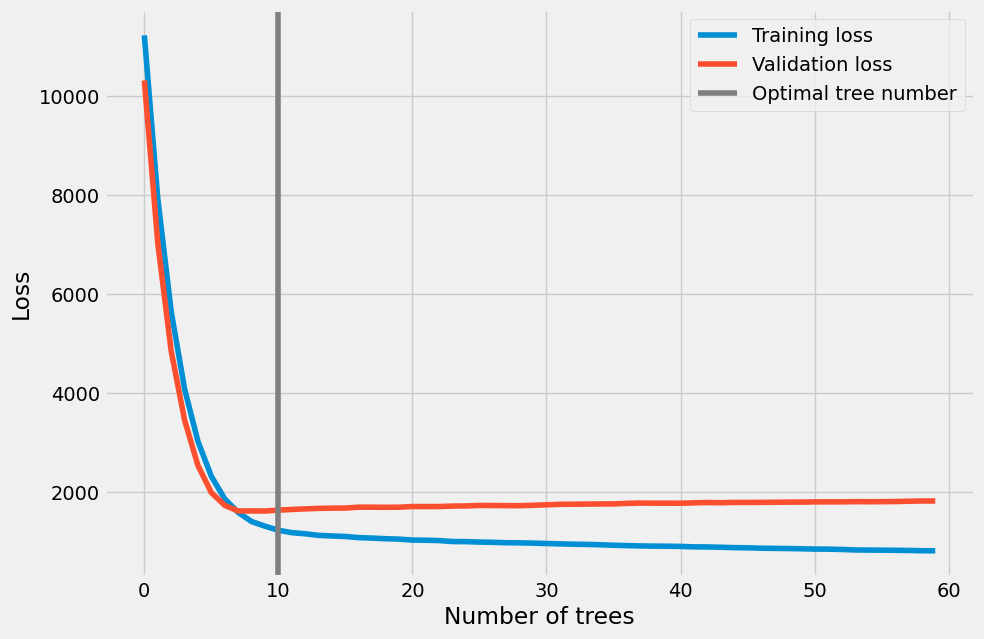

In [ ]:
results = reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(10, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

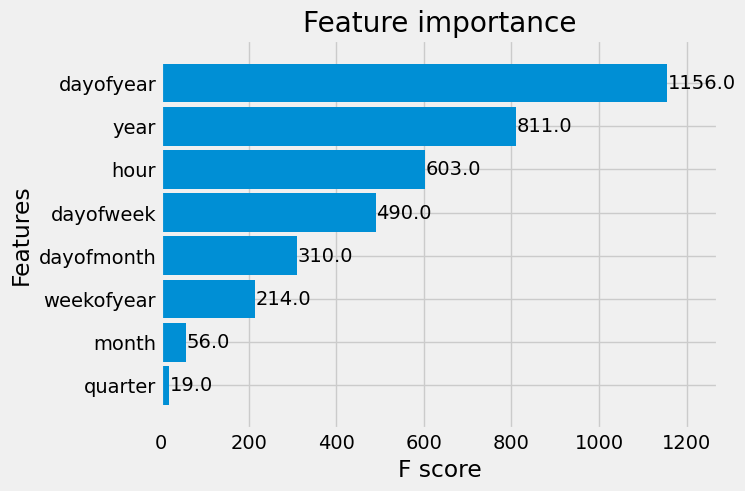

In [ ]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [ ]:
pjme_test['MW_Prediction'] = reg.predict(X_test, ntree_limit=reg.best_ntree_limit)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


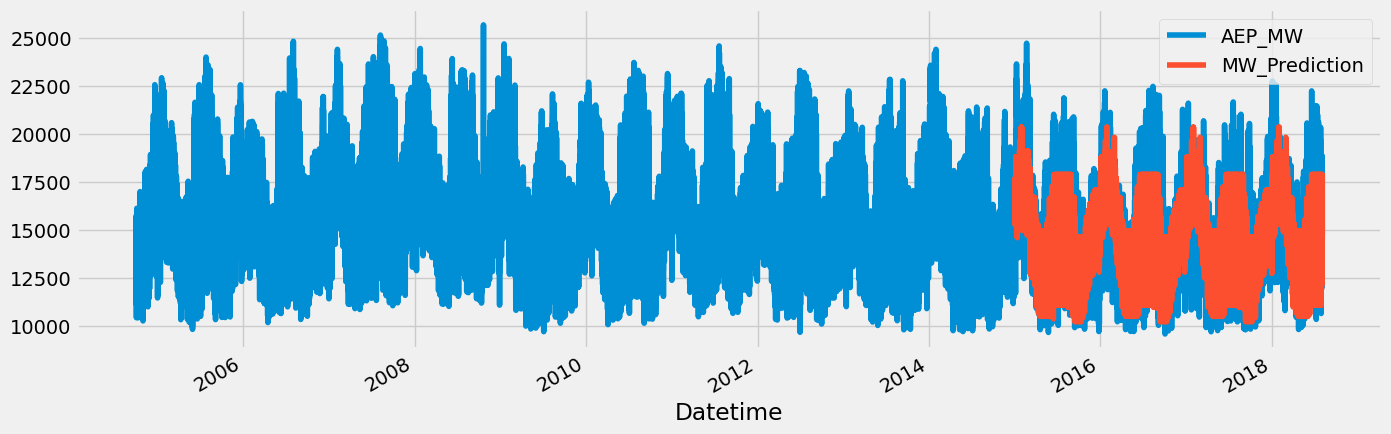

In [ ]:
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

/usr/local/lib/python3.10/dist-packages/matplotlib/axis.py:1732: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  ret = self.converter.convert(x, self.units, self)


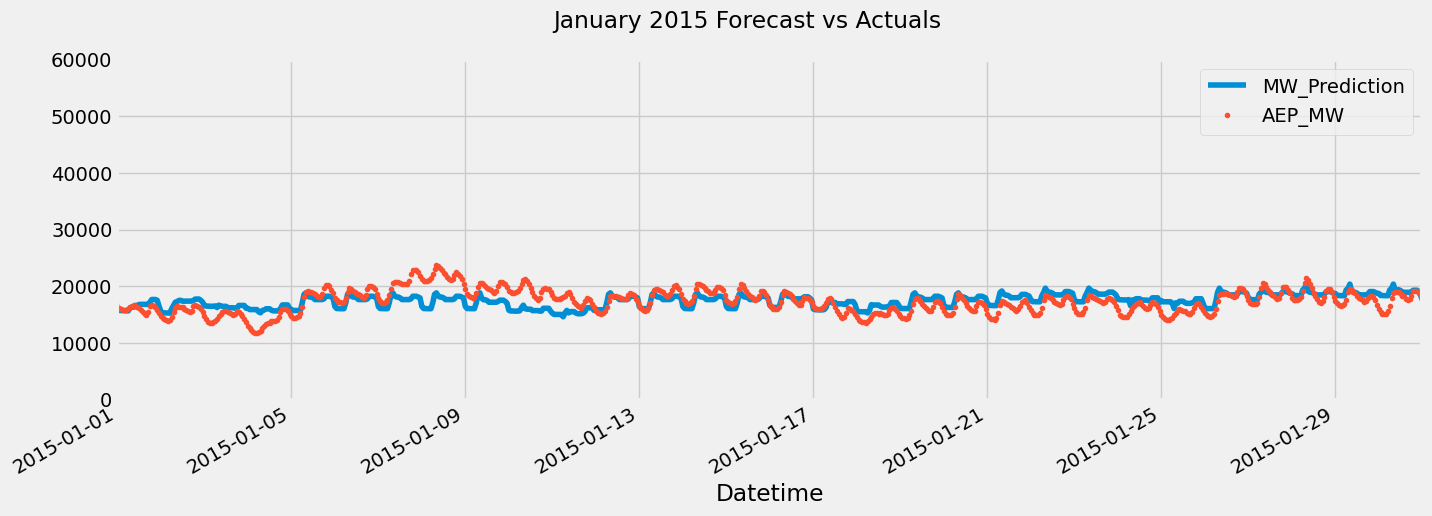

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='31-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

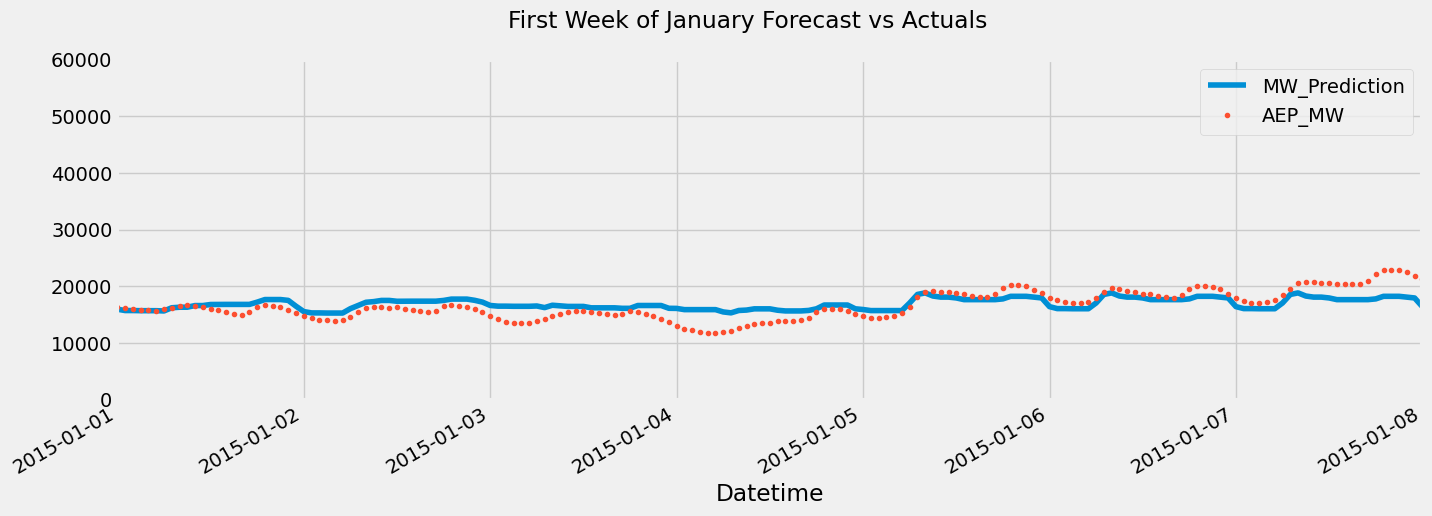

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

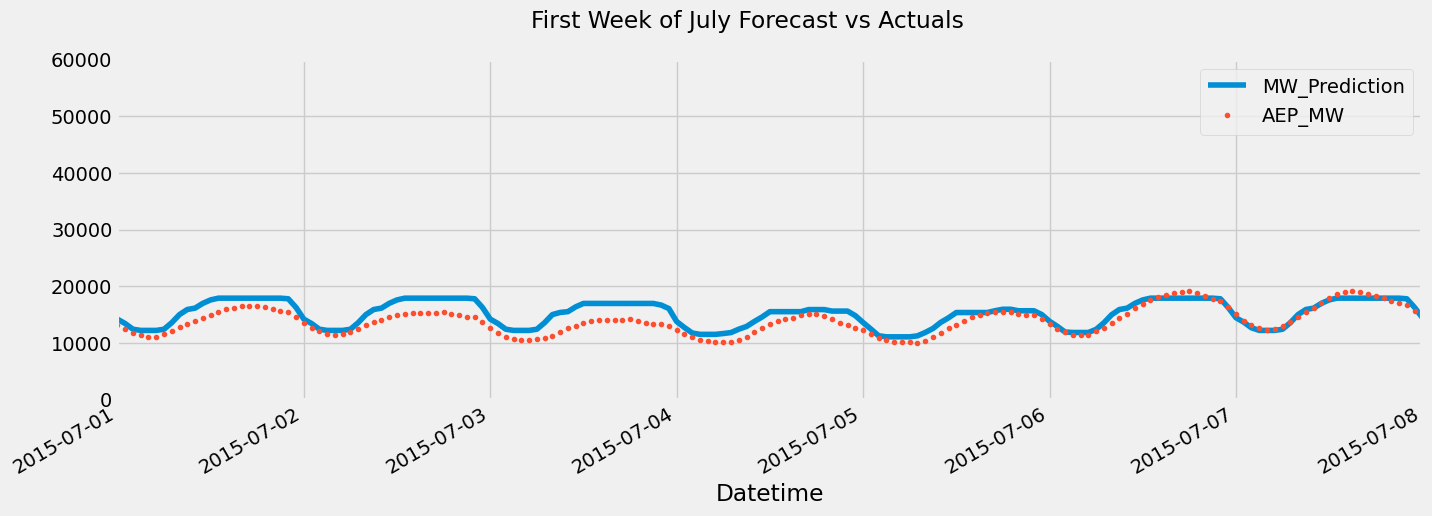

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 2603992.46

Our MAE error is 1237.15

Our MAPE error is 8.26%

In [ ]:
mean_squared_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2603992.4608340324

In [ ]:
mean_absolute_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

1237.1565526908894

I like using Mean Absolute Percent Error (MAPE) because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.269100832237395

# Look at Worst and Best Predicted Days

In [ ]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['AEP_MW','MW_Prediction','error','abs_error']]

<ipython-input-48-f4426ad61062>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()[['AEP_MW','MW_Prediction','error','abs_error']]


In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2017 1     22          12295.541667   16617.755859 -4322.213257  4322.213257
           21          12891.375000   16998.253906 -4106.878784  4106.878784
     2     23          13437.333333   17466.605469 -4029.272257  4029.272257
     1     23          14428.125000   18355.708984 -3927.583822  3927.583822
     2     24          13111.625000   17028.085938 -3916.460327  3916.460327
           22          13582.750000   17466.605469 -3883.855591  3883.855591
2018 1     22          14509.750000   18355.708984 -3845.958822  3845.958822
2015 12    25          11078.041667   14744.450195 -3666.408691  3666.408691
2017 1     25          14862.458333   18526.291016 -3663.832194  3663.832194
2016 7     4           12048.000000   15698.813477 -3650.813599  3650.813599

Notice anything about the over forecasted days?
- #1 worst day - July 4th, 2016 - is a holiday.
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 2     20          22047.041667   16497.130859  5549.910360  5549.910360
           19          22249.500000   16980.845703  5268.654704  5268.654704
2018 1     6           20847.833333   15838.145508  5009.687012  5009.687012
           7           19803.375000   15392.000977  4411.373657  4411.373657
2015 1     8           21873.333333   17498.212891  4375.120117  4375.120117
2017 1     22          12295.541667   16617.755859 -4322.213257  4322.213257
     12    28          19396.291667   15211.729492  4184.562541  4184.562541
2015 2     16          21129.791667   16985.570312  4144.221720  4144.221720
2017 1     21          12891.375000   16998.253906 -4106.878784  4106.878784
2018 1     2           20938.500000   16851.175781  4087.323649  4087.323649

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 11    8           14602.750000   14602.944336   -0.194499  203.348145
     10    28          12723.833333   12744.442383  -20.609945  214.556559
2018 6     23          14103.291667   14031.847656   71.444499  257.030436
     4     28          12237.583333   12252.049805  -14.466715  259.215576
2015 9     30          13556.583333   13707.753906 -151.170573  264.743652
2017 4     1           12569.208333   12430.795898  138.413249  267.858317
     11    16          14938.958333   14918.472656   20.485596  279.215413
2016 12    12          15836.333333   15871.379883  -35.046468  283.550537
     3     5           14801.166667   14795.766602    5.399740  290.247559
     12    2           15458.250000   15604.367188 -146.117350  291.865316

# Plotting some best/worst predicted days

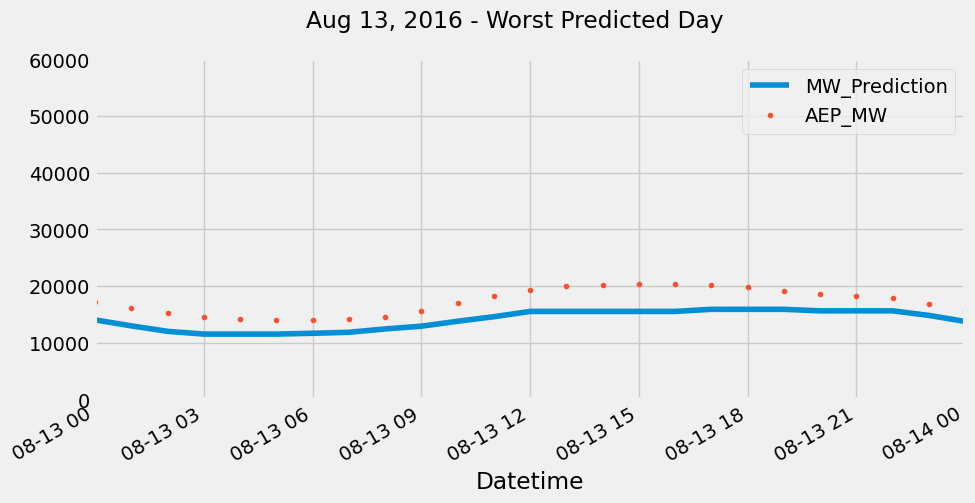

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

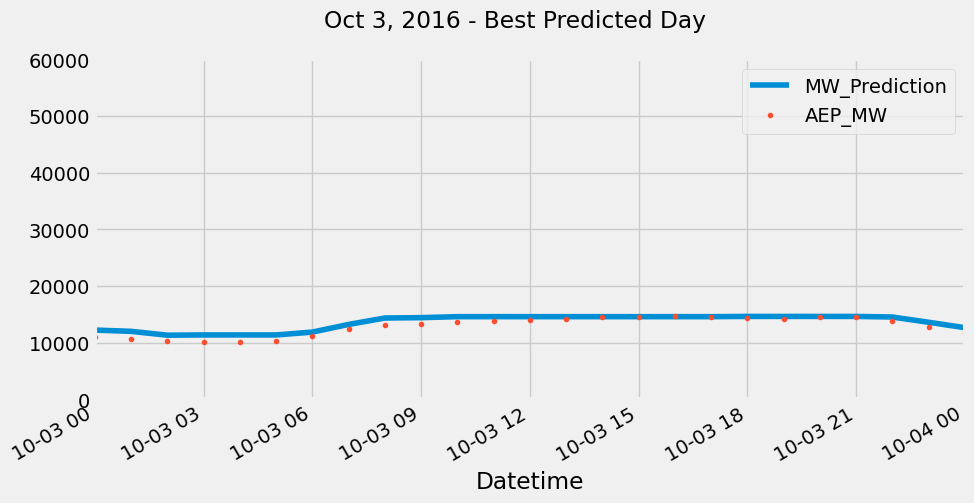

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

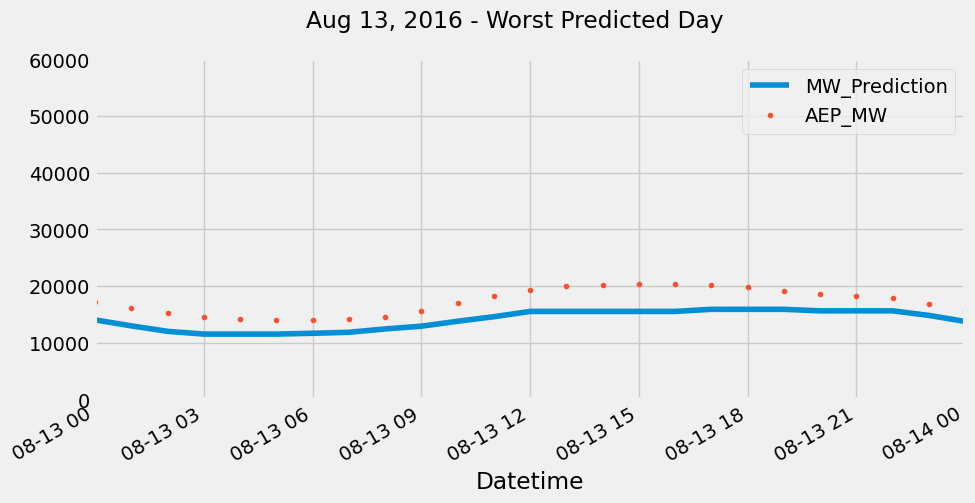

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source.

[To Understand the difference between Traditional vs ML Approach for Time Series Forecasing](https://www.youtube.com/watch?v=_ZQ-lQrK9Rg&list=LL&index=5)

[Another Case Study](https://www.youtube.com/watch?v=Wsfz3i1AXzY&list=LL&index=4)